### Сначала повторим результаты семинара

In [110]:
GAME="Skiing-v0"
IMAGE_W,IMAGE_H = IMAGE_SIZE =(160,100)
N_AGENTS = 10
SEQ_LENGTH = 25

from __future__ import print_function 
experiment_setup_name = "tutorial.gym.atari.skiing.cnn"

In [106]:
from __future__ import print_function 
import matplotlib.pyplot as plt
import numpy as np
import pygame
import theano
import theano.tensor as T
from scipy.misc import imresize
%matplotlib inline
%env THEANO_FLAGS="floatX=float32"

env: THEANO_FLAGS="floatX=float32"


In [61]:
from env import Atari

#creating a game
atari = Atari(GAME,image_size=IMAGE_SIZE) 

action_names = np.array(atari.get_action_meanings())

obs = atari.step(0)[0]

plt.imshow(obs,interpolation='none')

OSError: You asked for game Skiing-v0 but path /home/ubuntu/env/lib/python3.5/site-packages/atari_py/atari_roms/Skiing-v0.bin does not exist

[2017-01-26 16:03:06,476] Making new env: Skiing-v0


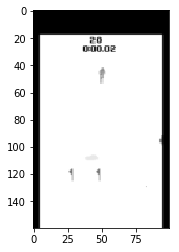

In [111]:
def preprocess(obs):
    return (imresize(obs,IMAGE_SIZE).mean(-1)/255.)

atari = gym.make(GAME)
atari.reset()
action_names = np.array(atari.get_action_meanings())

obs = atari.step(0)[0]

plt.imshow(preprocess(obs),interpolation='none',cmap='gray')

# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using simple convolutional neural network.

![scheme](https://s18.postimg.org/gbmsq6gmx/dqn_scheme.png)

In [5]:
import lasagne

In [119]:
from lasagne.layers import InputLayer, DimshuffleLayer

#image observation at current tick goes here, shape = (sample_i,x,y,color)
observation_layer = InputLayer((None,IMAGE_W,IMAGE_H))

#reshape to [sample, color, x, y] to allow for convolutional layers to work correctly
# observation_reshape = DimshuffleLayer(observation_layer,(0,3,1,2))



from agentnet.memory import WindowAugmentation,LSTMCell,RNNCell

#store 4-tick window in order to perceive motion of objects

prev_window = InputLayer((None,4,IMAGE_W,IMAGE_H))

current_window = WindowAugmentation(observation_layer,prev_window)



In [120]:


from lasagne.layers import Conv2DLayer,Pool2DLayer,DenseLayer,batch_norm,dropout

#main neural network body
conv0 = Conv2DLayer(current_window,32,filter_size=(8,8),stride=(4,4),name='conv0')

conv1 = Conv2DLayer(batch_norm(conv0),64,filter_size=(4,4),stride=(2,2),name='conv1')

dense0 = DenseLayer(batch_norm(conv1),512,name='dense',nonlinearity = lasagne.nonlinearities.tanh)

#please set this to your last layer for convenience
last_layer = dense0

In [126]:
#a layer that predicts Qvalues
qvalues_layer = DenseLayer(last_layer,
                   num_units = n_actions,
                   nonlinearity=lasagne.nonlinearities.linear,
                   name="q-evaluator layer")

#To pick actions, we use an epsilon-greedy resolver (epsilon is a property)
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer,name="e-greedy action picker")

action_layer.epsilon.set_value(np.float32(0.1))

In [127]:
from agentnet.target_network import TargetNetwork
targetnet = TargetNetwork(qvalues_layer,dense0)

In [128]:


qvalues_old = targetnet.output_layers



In [113]:
# %%time 
from lasagne.layers import Conv2DLayer,Pool2DLayer,DenseLayer,batch_norm,dropout

cnn = Conv2DLayer(observation_reshape, 16, filter_size=(8,8),stride=(4,4),name='l0')
cnn = Conv2DLayer(cnn, 32,filter_size=(5,5),stride=(4,4),name='l1')
cnn = Conv2DLayer(cnn, 64,filter_size=(4,4),stride=(4,4),name='l2')
dnn = DenseLayer(cnn, 256, nonlinearity=lasagne.nonlinearities.tanh, name='dense')
last_layer = dnn

In [121]:
#a layer that predicts Qvalues for all actions.
# Just adense layer with corresponding number of units and no nonlinearity (lasagne.nonlinearity.linear)
n_actions = atari.action_space.n
qvalues_layer = DenseLayer(last_layer,
                   num_units = n_actions,
                   nonlinearity=lasagne.nonlinearities.linear,
                   name="QEvaluator")

#To pick actions, we use an epsilon-greedy resolver (epsilon is a property)
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer,name="e-greedy action picker")

action_layer.epsilon.set_value(np.float32(0.1))


In [122]:
from agentnet.agent import Agent
agent = Agent(observation_layers=observation_layer,
              policy_estimators=qvalues_layer,
              action_layers=action_layer)


In [129]:


from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=(qvalues_layer,qvalues_old),
              agent_states={current_window:prev_window},
              action_layers=action_layer)



In [130]:
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[conv0.W,
 conv0_bn.beta,
 conv0_bn.gamma,
 conv1.W,
 conv1_bn.beta,
 conv1_bn.gamma,
 dense.W,
 dense.b,
 q-evaluator layer.W,
 q-evaluator layer.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [55]:
"""
A thin wrapper for openAI gym environments that maintains a set of parallel games and has a method to generate
interaction sessions given agent one-step applier function.
"""

import numpy as np
from agentnet.environment import SessionPoolEnvironment
from agentnet.utils.layers import get_layer_dtype
from warnings import warn
import gym
from gym.wrappers import Monitor



def GamePool(*args, **kwargs):
    raise ValueError("Deprecated. Use EnvPool(agent,env_title,n_parallel_agents) instead")


deprecated_preprocess_obs = lambda obs: obs

# A whole lot of space invaders
class EnvPool(object):
    def __init__(self, agent, make_env=lambda: gym.make("skiing-v0"), n_games=1, max_size=None,
                 preprocess_observation=deprecated_preprocess_obs, agent_step=None):
        """A pool that stores several
           - game states (gym environment)
           - prev observations - last agent observations
           - prev memory states - last agent hidden states
        and is capable of some auxilary actions like evaluating agent on one game session (See .evaluate()).
        :param agent: Agent which interacts with the environment.
        :type agent: agent.Agent
        :param make_env: Factory that produces environments OR a name of the gym environment.
                See gym.envs.registry.all()
        :type make_env: function or str
        :param n_games: Number of parallel games. One game by default.
        :type n_games: int
        :param max_size: Max pool size by default (if appending sessions). By default, pool is not constrained in size.
        :type max_size: int
        :param preprocess_observation: Function for preprocessing raw observations from gym env to agent format.
            By default it is identity function.
        :type preprocess_observation: function
        :param agent_step: Function with the same signature as agent.get_react_function().
        :type agent_step: theano.function
        """
        if not callable(make_env):
            env_name = make_env
            make_env = lambda: gym.make(env_name)

        ##Deprecation warning
        if preprocess_observation != deprecated_preprocess_obs:
            warn("preprocess_observation is deprecated (will be removed in 0.11). Use gym.core.Wrapper instead.")

        # Create atari games.
        self.make_env = make_env
        self.envs = [self.make_env() for _ in range(n_games)]
        self.preprocess_observation = preprocess_observation

        # Initial observations.
        self.prev_observations = [self.preprocess_observation(make_env.reset()) for make_env in self.envs]

        # Agent memory variables (if you use recurrent networks).
        self.prev_memory_states = [np.zeros((n_games,) + tuple(mem.output_shape[1:]),
                                            dtype=get_layer_dtype(mem))
                                   for mem in agent.agent_states]

        # Save agent.
        self.agent = agent
        self.agent_step = agent_step or agent.get_react_function()

        # Create experience replay environment.
        self.experience_replay = SessionPoolEnvironment(observations=agent.observation_layers,
                                                        actions=agent.action_layers,
                                                        agent_memories=agent.agent_states)
        self.max_size = max_size

        # Whether particular session has just been terminated and needs restarting.
        self.just_ended = [False] * len(self.envs)

    def interact(self, n_steps=100, verbose=False, add_last_observation=True):
        """Generate interaction sessions with ataries (openAI gym atari environments)
        Sessions will have length n_steps. Each time one of games is finished, it is immediately getting reset
        and this time is recorded in is_alive_log (See returned values).
        :param n_steps: Length of an interaction.
        :param verbose: If True, prints small debug message whenever a game gets reloaded after end.
        :param add_last_observation: If True, appends the final state with
                state=final_state,
                action=-1,
                reward=0,
                new_memory_states=prev_memory_states, effectively making n_steps-1 records.
        :returns: observation_log, action_log, reward_log, [memory_logs], is_alive_log, info_log
        :rtype: a bunch of tensors [batch, tick, size...],
                the only exception is info_log, which is a list of infos for [time][batch], None padded tick
        """

        def env_step(i, action):
            """Environment reaction.
            :returns: observation, reward, is_alive, info
            """

            if not self.just_ended[i]:
                new_observation, cur_reward, is_done, info = self.envs[i].step(action)
                if is_done:
                    # Game ends now, will finalize on next tick.
                    self.just_ended[i] = True
                new_observation = self.preprocess_observation(new_observation)

                # note: is_alive=True in any case because environment is still alive (last tick alive) in our notation.
                return new_observation, cur_reward, True, info
            else:
                # Reset environment, get new observation to be used on next tick.
                new_observation = self.preprocess_observation(self.envs[i].reset())

                # Reset memory for new episode.
                for m_i in range(len(new_memory_states)):
                    new_memory_states[m_i][i] = 0

                if verbose:
                    print("env %i reloaded" % i)

                self.just_ended[i] = False

                return new_observation, 0, False, {'end': True}

        history_log = []

        for i in range(n_steps - int(add_last_observation)):
            res = self.agent_step(self.prev_observations, *self.prev_memory_states)
            actions, new_memory_states = res[0], res[1:]

            new_observations, cur_rewards, is_alive, infos = zip(*map(env_step, range(len(self.envs)), actions))

            # Append data tuple for this tick.
            history_log.append((self.prev_observations, actions, cur_rewards, new_memory_states, is_alive, infos))

            self.prev_observations = new_observations
            self.prev_memory_states = new_memory_states

        if add_last_observation:
            fake_actions = np.array([env.action_space.sample() for env in self.envs])
            fake_rewards = np.zeros(shape=len(self.envs))
            fake_is_alive = np.ones(shape=len(self.envs))
            history_log.append((self.prev_observations, fake_actions, fake_rewards, self.prev_memory_states,
                                fake_is_alive, [None] * len(self.envs)))

        # cast to numpy arrays
        observation_log, action_log, reward_log, memories_log, is_alive_log, info_log = zip(*history_log)

        # tensor dimensions
        # [batch_i, time_i, observation_size...]
        observation_log = np.array(observation_log).swapaxes(0, 1)

        # [batch, time, units] for each memory tensor
        memories_log = list(map(lambda mem: np.array(mem).swapaxes(0, 1), zip(*memories_log)))

        # [batch_i,time_i]
        action_log = np.array(action_log).swapaxes(0, 1)

        # [batch_i, time_i]
        reward_log = np.array(reward_log).swapaxes(0, 1)

        # [batch_i, time_i]
        is_alive_log = np.array(is_alive_log).swapaxes(0, 1).astype('uint8')

        return observation_log, action_log, reward_log, memories_log, is_alive_log, info_log

    def update(self, n_steps=100, append=False, max_size=None, add_last_observation=True,
               preprocess=lambda observations, actions, rewards, is_alive, h0: (
                       observations, actions, rewards, is_alive, h0)):
        """Create new sessions and add them into the pool.
        :param n_steps: How many time steps in each session.
        :param append: If True, appends sessions to the pool and crops at max_size.
            Otherwise, old sessions will be thrown away entirely.
        :param max_size: If not None, substitutes default max_size (from __init__) for this update only.
        :param add_last_observation: See param `add_last_observation` in `.interact()` method.
        :param preprocess: Function that implements arbitrary processing of the sessions.
            Takes AND outputs (observation_tensor, action_tensor, reward_tensor, is_alive_tensor, preceding_memory_states).
            For param specs see `.interact()` output format.
        """

        preceding_memory_states = list(self.prev_memory_states)

        # Get interaction sessions.
        observation_tensor, action_tensor, reward_tensor, _, is_alive_tensor, _ = self.interact(n_steps=n_steps,
                                                                                                add_last_observation=add_last_observation)

        observation_tensor, action_tensor, reward_tensor, is_alive_tensor, preceding_memory_states = \
            preprocess(observation_tensor, action_tensor, reward_tensor, is_alive_tensor, preceding_memory_states)

        # Load them into experience replay environment.
        if not append:
            self.experience_replay.load_sessions(observation_tensor, action_tensor, reward_tensor,
                                                 is_alive_tensor, preceding_memory_states)
        else:
            self.experience_replay.append_sessions(observation_tensor, action_tensor, reward_tensor,
                                                   is_alive_tensor, preceding_memory_states,
                                                   max_pool_size=max_size or self.max_size)

    def evaluate(self, n_games=1, save_path="./records", use_monitor=True, record_video=True, verbose=True,
                 t_max=10000):
        """Plays an entire game start to end, records the logs(and possibly mp4 video), returns reward.
        :param save_path: where to save the report
        :param record_video: if True, records mp4 video
        :return: total reward (scalar)
        """
        env = self.make_env()

        if not use_monitor and record_video:
            raise warn("Cannot video without gym monitor. If you still want video, set use_monitor to True")

        if record_video :
            env = Monitor(env,save_path,force=True)
        elif use_monitor:
            env = Monitor(env, save_path, video_callable=lambda i: False, force=True)

        game_rewards = []
        for _ in range(n_games):
            # initial observation
            observation = env.reset()
            # initial memory
            prev_memories = [np.zeros((1,) + tuple(mem.output_shape[1:]),
                                      dtype=get_layer_dtype(mem))
                             for mem in self.agent.agent_states]

            t = 0
            total_reward = 0
            while True:

                res = self.agent_step(self.preprocess_observation(observation)[None, ...], *prev_memories)
                action, new_memories = res[0], res[1:]

                observation, reward, done, info = env.step(action[0])

                total_reward += reward
                prev_memories = new_memories

                if done or t >= t_max:
                    if verbose:
                        print("Episode finished after {} timesteps with reward={}".format(t + 1, total_reward))
                    break
                t += 1
            game_rewards.append(total_reward)

        env.close()
        del env
        return game_rewards

In [44]:
"""
A thin wrapper for openAI gym environments that maintains a set of parallel games and has a method to generate interaction sessions
given agent one-step applier function
"""

from env import Atari
import numpy as np
from gym.wrappers import Monitor

from agentnet.environment import SessionPoolEnvironment
from agentnet.utils.layers import get_layer_dtype

# A whole lot of space invaders
class AtariGamePool(object):
    def __init__(self, agent,game_title, n_games,max_size=None, **kwargs):
        """
        A pool that stores several
           - game states (gym environment)
           - prev_observations - last agent observations
           - prev memory states - last agent hidden states

        :param game_title: name of the game. See here http://yavar.naddaf.name/ale/list_of_current_games.html
        :param n_games: number of parallel games
        :param kwargs: options passed to Atari when creating a game. See Atari __init__
        """
        #create atari games
        self.game_kwargs = kwargs
        self.game_title = game_title
        self.games = [Atari(self.game_title,**self.game_kwargs) for _ in range(n_games)]

        #initial observations
        self.prev_observations = [atari.reset() for atari in self.games]

        #agent memory variables (if you use recurrent networks
        self.prev_memory_states = [np.zeros((n_games,)+tuple(mem.output_shape[1:]),
                                   dtype=get_layer_dtype(mem))
                         for mem in agent.agent_states]

        #save agent
        self.agent = agent
        self.agent_step = agent.get_react_function()

        # Create experience replay environment
        self.experience_replay = SessionPoolEnvironment(observations=agent.observation_layers,
                                                        actions=agent.action_layers,
                                                        agent_memories=agent.agent_states)
        self.max_size = max_size



    def interact(self, n_steps=100, verbose=False):
        """generate interaction sessions with ataries (openAI gym atari environments)
        Sessions will have length n_steps.
        Each time one of games is finished, it is immediately getting reset


        params:
            agent_step: a function(observations,memory_states) -> actions,new memory states for agent update
            n_steps: length of an interaction
            verbose: if True, prints small debug message whenever a game gets reloaded after end.
        returns:
            observation_log,action_log,reward_log,[memory_logs],is_alive_log,info_log
            a bunch of tensors [batch, tick, size...]

            the only exception is info_log, which is a list of infos for [time][batch]
        """
        history_log = []
        for i in range(n_steps):
            res = self.agent_step(self.prev_observations, *self.prev_memory_states)
            actions, new_memory_states = res[0],res[1:]

            new_observations, cur_rewards, is_done, infos = \
                zip(*map(
                    lambda atari, action: atari.step(action),
                    self.games,
                    actions)
                    )

            new_observations = np.array(new_observations)

            for i in range(len(self.games)):
                if is_done[i]:
                    new_observations[i] = self.games[i].reset()

                    for m_i in range(len(new_memory_states)):
                        new_memory_states[m_i][i] = 0

                    if verbose:
                        print("atari %i reloaded" % i)

            # append observation -> action -> reward tuple
            history_log.append((self.prev_observations, actions, cur_rewards, new_memory_states, is_done, infos))

            self.prev_observations = new_observations
            self.prev_memory_states = new_memory_states

        # cast to numpy arrays
        observation_log, action_log, reward_log, memories_log, is_done_log, info_log = zip(*history_log)

        # tensor dimensions
        # [batch_i, time_i, observation_size...]
        observation_log = np.array(observation_log).swapaxes(0, 1)

        # [batch, time, units] for each memory tensor
        memories_log = map(lambda mem: np.array(mem).swapaxes(0, 1), zip(*memories_log))

        # [batch_i,time_i]
        action_log = np.array(action_log).swapaxes(0, 1)

        # [batch_i, time_i]
        reward_log = np.array(reward_log).swapaxes(0, 1)

        # [batch_i, time_i]
        is_alive_log = 1 - np.array(is_done_log, dtype='int8').swapaxes(0, 1)


        return observation_log, action_log, reward_log, memories_log, is_alive_log, info_log


    def update(self,n_steps=100,append=False,max_size=None):
        """ a function that creates new sessions and ads them into the pool
        throwing the old ones away entirely for simplicity"""

        preceding_memory_states = list(self.prev_memory_states)

        # get interaction sessions
        observation_tensor, action_tensor, reward_tensor, _, is_alive_tensor, _ = self.interact(n_steps=n_steps)

        # load them into experience replay environment
        if not append:
            self.experience_replay.load_sessions(observation_tensor, action_tensor, reward_tensor,
                                                 is_alive_tensor, preceding_memory_states)
        else:
            self.experience_replay.append_sessions(observation_tensor, action_tensor, reward_tensor,
                                                 is_alive_tensor, preceding_memory_states,
                                                   max_pool_size=max_size or self.max_size)


    def evaluate(self,n_games=1,save_path="./records", record_video=True,verbose=True,t_max=10000):
        """
        Plays an entire game start to end, records the logs(and possibly mp4 video), returns reward
        :param save_path: where to save the report
        :param record_video: if True, records mp4 video
        :return: total reward (scalar)
        """
        env = Atari(self.game_title, **self.game_kwargs)

        if record_video :
            env = Monitor(env,save_path,force=True)
        elif use_monitor:
            env = Monitor(env, save_path, video_callable=lambda i: False, force=True)

        game_rewards = []
        for _ in range(n_games):
            # initial observation
            observation = env.reset()
            # initial memory
            prev_memories = [np.zeros((1,) + tuple(mem.output_shape[1:]),
                                      dtype=get_layer_dtype(mem))
                             for mem in self.agent.agent_states]

            t = 0
            total_reward = 0
            while True:

                res = self.agent_step(observation[None,...], *prev_memories)
                action, new_memories = res[0],res[1:]

                observation, reward, done, info = env.step(action[0])
                total_reward += reward
                prev_memories = new_memories

                if done or t >= t_max:
                    if verbose:
                        print("Episode finished after {} timesteps with reward={}".format(t + 1,total_reward))
                    break
                t += 1
            game_rewards.append(total_reward)

        env.monitor.close()
        del env
        return np.mean(game_rewards)

In [45]:
# from pool import AtariGamePool
pool = AtariGamePool(agent,GAME, N_AGENTS,image_size=IMAGE_SIZE)

In [133]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent, lambda: gym.make(GAME), 
               preprocess_observation=preprocess,
               n_games=N_AGENTS,max_size=1000)

/home/ubuntu/AgentNet/agentnet/experiments/openai_gym/pool.py:58: UserWarning: preprocess_observation is deprecated (will be removed in 0.11). Use gym.core.Wrapper instead.
  warn("preprocess_observation is deprecated (will be removed in 0.11). Use gym.core.Wrapper instead.")
[2017-01-26 16:12:03,018] Making new env: Skiing-v0
[2017-01-26 16:12:03,064] Making new env: Skiing-v0
[2017-01-26 16:12:03,102] Making new env: Skiing-v0
[2017-01-26 16:12:03,140] Making new env: Skiing-v0
[2017-01-26 16:12:03,180] Making new env: Skiing-v0
[2017-01-26 16:12:03,216] Making new env: Skiing-v0
[2017-01-26 16:12:03,245] Making new env: Skiing-v0
[2017-01-26 16:12:03,289] Making new env: Skiing-v0
[2017-01-26 16:12:03,331] Making new env: Skiing-v0
[2017-01-26 16:12:03,367] Making new env: Skiing-v0
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir/lock
[2017-01-26 16:12:05,360] Refreshing lock /

In [131]:
pool = EnvPool(agent,lambda: gym.make(GAME), N_AGENTS)

[2017-01-26 16:09:58,980] Making new env: Skiing-v0
[2017-01-26 16:09:59,023] Making new env: Skiing-v0
[2017-01-26 16:09:59,065] Making new env: Skiing-v0
[2017-01-26 16:09:59,107] Making new env: Skiing-v0
[2017-01-26 16:09:59,149] Making new env: Skiing-v0
[2017-01-26 16:09:59,194] Making new env: Skiing-v0
[2017-01-26 16:09:59,238] Making new env: Skiing-v0
[2017-01-26 16:09:59,279] Making new env: Skiing-v0
[2017-01-26 16:09:59,320] Making new env: Skiing-v0
[2017-01-26 16:09:59,362] Making new env: Skiing-v0


KeyboardInterrupt: 

In [134]:
%%time
_,action_log,reward_log,_,_,_  = pool.interact(7)
print(action_names[action_log])
print(reward_log)

[['RIGHT' 'NOOP' 'RIGHT' 'LEFT' 'LEFT' 'LEFT' 'NOOP']
 ['RIGHT' 'RIGHT' 'LEFT' 'LEFT' 'NOOP' 'LEFT' 'RIGHT']
 ['RIGHT' 'RIGHT' 'LEFT' 'LEFT' 'LEFT' 'NOOP' 'NOOP']
 ['RIGHT' 'RIGHT' 'LEFT' 'LEFT' 'LEFT' 'LEFT' 'RIGHT']
 ['RIGHT' 'RIGHT' 'LEFT' 'LEFT' 'LEFT' 'LEFT' 'RIGHT']
 ['RIGHT' 'RIGHT' 'LEFT' 'LEFT' 'LEFT' 'LEFT' 'LEFT']
 ['RIGHT' 'RIGHT' 'LEFT' 'LEFT' 'LEFT' 'LEFT' 'NOOP']
 ['RIGHT' 'RIGHT' 'LEFT' 'RIGHT' 'LEFT' 'LEFT' 'LEFT']
 ['RIGHT' 'RIGHT' 'LEFT' 'LEFT' 'LEFT' 'LEFT' 'NOOP']
 ['RIGHT' 'RIGHT' 'LEFT' 'LEFT' 'LEFT' 'LEFT' 'NOOP']]
[[-3. -4. -3. -5. -3. -7.  0.]
 [-7. -3. -3. -5. -4. -6.  0.]
 [-3. -7. -5. -7. -6. -7.  0.]
 [-3. -5. -7. -5. -5. -7.  0.]
 [-5. -5. -5. -5. -3. -4.  0.]
 [-3. -4. -5. -3. -5. -3.  0.]
 [-5. -3. -5. -5. -7. -3.  0.]
 [-3. -5. -4. -5. -5. -5.  0.]
 [-3. -4. -3. -3. -7. -3.  0.]
 [-3. -4. -5. -5. -3. -5.  0.]]
CPU times: user 276 ms, sys: 16 ms, total: 292 ms
Wall time: 293 ms


In [135]:
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# Q-learning
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (Q-learning objective)

In [137]:
#get agent's Qvalues obtained via experience replay.

#This is an "environment" that replays all stored sessions.
# replay = pool.experience_replay

#To only sample several random sessions, try
replay = pool.experience_replay.sample_session_batch(100,replace=True)

_,_,_,_,qvalues_seq = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    optimize_experience_replay=True,
)


/home/ubuntu/AgentNet/agentnet/agent/mdp_agent.py:144: UserWarning: optimize_experience_replay is deprecated and will be removed in 1.0.2. Use experience_replay parameter.
  warn("optimize_experience_replay is deprecated and will be removed in 1.0.2. Use experience_replay parameter.")


In [141]:
qvalues_seq

[InplaceDimShuffle{1,0,2}.0, InplaceDimShuffle{1,0,2}.0]

In [142]:
#get reference Qvalues according to Qlearning algorithm
from agentnet.learning import qlearning

#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2

elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq[0],
                                                      replay.actions[0],
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      gamma_or_gammas=0.99,)

#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [143]:
# Compute weight updates. Replace with any optimizer you want
updates = lasagne.updates.adam(loss,weights)

In [144]:
#compile train function
train_step = theano.function([],loss,updates=updates)

INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir/lock
[2017-01-26 16:16:42,749] Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir/lock
[2017-01-26 16:22:55,960] Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir/lock
[2017-01-26 16:23:56,807] Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ub

In [145]:
def get_epsilon(epoch_counter):
    return 0.05 + 0.45*np.exp(-epoch_counter/1000.)

In [146]:
untrained_reward = pool.evaluate(save_path="./records",record_video=True)

[2017-01-26 16:29:43,514] Making new env: Skiing-v0
[2017-01-26 16:29:43,571] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-26 16:29:43,572] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-01-26 16:29:43,590] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.0.27462.video000000.mp4
[2017-01-26 16:30:39,543] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Episode finished after 5976 timesteps with reward=-30000.0


In [147]:
epoch_counter = 1
rewards = {epoch_counter:untrained_reward}

In [151]:
for i in range(3000):
    pool.update(SEQ_LENGTH)
    loss = train_step()
    ##update resolver's epsilon (chance of random action instead of optimal one)
    current_epsilon = get_epsilon(epoch_counter)
    action_layer.epsilon.set_value(np.float32(current_epsilon))
    
    if epoch_counter%10==0:
        print("iter=%i\tepsilon=%.3f"%(epoch_counter,current_epsilon))
    
    ##record current learning progress and show learning curves
    if epoch_counter%100 ==0:
        rewards[epoch_counter] = pool.evaluate(record_video=False)
        
        plt.title("random frames")
        for i in range(min((len(pool.games),6))):
            plt.subplot(2,3,i+1)
            plt.imshow(pool.games[i].get_observation())
        plt.show()

    
    epoch_counter  +=1
    
# Time to drink some coffee!

MemoryError: Error allocating 2560000 bytes of device memory (out of memory).
Apply node that caused the error: GpuFromHost(input)
Toposort index: 14
Inputs types: [TensorType(float32, 4D)]
Inputs shapes: [(10, 4, 160, 100)]
Inputs strides: [(256000, 64000, 400, 4)]
Inputs values: ['not shown']
Outputs clients: [[GpuSubtensor{::, :int64:}(GpuFromHost.0, Constant{-1})]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [23]:
rw = pool.evaluate(n_games=1,save_path="./records",record_video=True)
print("mean session score=%f.5"%rw)

[2016-10-29 00:04:30,455] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
INFO:gym.monitoring.monitor:Clearing 2 monitor files from previous run (because force=True was provided)
[2016-10-29 00:04:30,456] Clearing 2 monitor files from previous run (because force=True was provided)
INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /notebooks/Fold2/records/openaigym.video.31.8158.video000000.mp4
[2016-10-29 00:04:30,507] Starting new video recorder writing to /notebooks/Fold2/records/openaigym.video.31.8158.video000000.mp4
INFO:gym.monitoring.monitor:Finished writing results. You can upload them to the scoreboard via gym.upload('/notebooks/Fold2/records')
[2016-10-29 00:04:43,613] Finished writing results. You can upload them to the scoreboard via gym.upload('/notebooks/Fold2/records')


Episode finished after 1961 timesteps with reward=800.0
mean session score=800.000000.5


## Улучшение результата: 

https://github.com/yandexdataschool/AgentNet/blob/master/docs/user/whats_what.md

### Recurrent memory cells:

In [149]:
from lasagne.layers import InputLayer,DropoutLayer,DenseLayer, ExpressionLayer, Conv2DLayer,MaxPool2DLayer
from lasagne.layers import flatten, dimshuffle

observation_layer = InputLayer((None,IMAGE_W,IMAGE_H,3))
observation_reshape = DimshuffleLayer(observation_layer,(0,3,1,2))
observation_small = lasagne.layers.Pool2DLayer(observation_reshape,(2,2),mode='average_exc_pad')

cnn = Conv2DLayer(observation_small, num_filters=64, filter_size=(8,8), stride=(4,4))
cnn = Conv2DLayer(cnn, num_filters=128, filter_size=(4,4), stride=(2,2))

dnn = DenseLayer(cnn,num_units=500)
dnn = DropoutLayer(dnn,name = "dropout", p=0.05)
dnn = DenseLayer(dnn,num_units=500)
last_layer = dnn

MemoryError: ('Error allocating 8192000 bytes of device memory (out of memory).', "you might consider using 'theano.shared(..., borrow=True)'")

In [126]:
from agentnet.memory import WindowAugmentation, GRUMemoryLayer

window_size = 3
prev_window = InputLayer((None,window_size,last_layer.output_shape[1]))
window = WindowAugmentation(last_layer, prev_window)

gru_size = 256
prev_gru = InputLayer((None,gru_size))

window_max = ExpressionLayer(window,function=lambda v: v.max(axis=1), output_shape=last_layer.output_shape)
window_max = lasagne.layers.FeaturePoolLayer(window,window_size)

gru = GRUMemoryLayer(gru_size, observation_input = window_max, prev_state_input = prev_gru)

from collections import OrderedDict
memory_dict = OrderedDict([(window,prev_window), (gru,prev_gru)])

### Actor Critic

In [127]:
#Critic
state_value_layer = DenseLayer(gru,
                               num_units = 1,
                               nonlinearity = lasagne.nonlinearities.linear)
n_actions = atari.action_space.n
#Actor
policy_layer_pre_softmax = DenseLayer(gru,
                                     num_units = n_actions,
                                     nonlinearity= None)

from lasagne.layers import NonlinearityLayer
policy_layer = NonlinearityLayer(policy_layer_pre_softmax,
                                 lasagne.nonlinearities.softmax)


#probabilistic resolver instead of greedy
from agentnet.resolver import ProbabilisticResolver
action_layer = ProbabilisticResolver(policy_layer,assume_normalized=True,name="resolver")

In [128]:
from agentnet.agent import Agent
agent = Agent(observation_layers=observation_layer,
              agent_states=memory_dict,
              policy_estimators=[policy_layer,state_value_layer],
              action_layers=action_layer)

In [129]:
weights = lasagne.layers.get_all_params((action_layer,state_value_layer),trainable=True)
weights

[W,
 b,
 W,
 b,
 W,
 b,
 W,
 b,
 YetAnotherGRUMemoryLayer.W_in_to_updategate,
 YetAnotherGRUMemoryLayer.W_hid_to_updategate,
 YetAnotherGRUMemoryLayer.b_updategate,
 YetAnotherGRUMemoryLayer.W_in_to_resetgate,
 YetAnotherGRUMemoryLayer.W_hid_to_resetgate,
 YetAnotherGRUMemoryLayer.b_resetgate,
 YetAnotherGRUMemoryLayer.W_in_to_hidden_update,
 YetAnotherGRUMemoryLayer.W_hid_to_hidden_update,
 YetAnotherGRUMemoryLayer.b_hidden_update,
 W,
 b,
 W,
 b]

In [130]:
from agentnet.experiments.openai_gym.pool import GamePool
from agentnet.environment import SessionPoolEnvironment

pool = GamePool(GAME, N_AGENTS)
replay = SessionPoolEnvironment(observations = observation_layer, actions=action_layer, agent_memories=agent.agent_states.keys())

INFO:gym.envs.registration:Making new env: KungFuMaster-v0
[2016-10-30 19:16:12,790] Making new env: KungFuMaster-v0
INFO:gym.envs.registration:Making new env: KungFuMaster-v0
[2016-10-30 19:16:12,830] Making new env: KungFuMaster-v0
INFO:gym.envs.registration:Making new env: KungFuMaster-v0
[2016-10-30 19:16:12,865] Making new env: KungFuMaster-v0
INFO:gym.envs.registration:Making new env: KungFuMaster-v0
[2016-10-30 19:16:12,904] Making new env: KungFuMaster-v0
INFO:gym.envs.registration:Making new env: KungFuMaster-v0
[2016-10-30 19:16:12,939] Making new env: KungFuMaster-v0
INFO:gym.envs.registration:Making new env: KungFuMaster-v0
[2016-10-30 19:16:12,974] Making new env: KungFuMaster-v0
INFO:gym.envs.registration:Making new env: KungFuMaster-v0
[2016-10-30 19:16:13,015] Making new env: KungFuMaster-v0
INFO:gym.envs.registration:Making new env: KungFuMaster-v0
[2016-10-30 19:16:13,055] Making new env: KungFuMaster-v0
INFO:gym.envs.registration:Making new env: KungFuMaster-v0
[2016

In [134]:
applier_fun = agent.get_react_function()

In [135]:
def step(observation, prev_memories='zeros', batch_size=N_AGENTS):
    if prev_memories == 'zeros':
        prev_memories = [np.zeros((batch_size,) + tuple(mem.output_shape[1:]), dtype='float32') for mem in agent.agent_states]
    res = applier_fun(np.array(observation), *prev_memories)
    action = res[0]
    memories = res[1:]
    return action, memories

def update_pool(replay, pool,n_steps=100):
    preceding_memory_states = list(pool.prev_memory_states)
    observation_tensor,action_tensor,reward_tensor,_,is_alive_tensor,_= pool.interact(step, n_steps)
    replay.load_sessions(observation_tensor,action_tensor,reward_tensor,is_alive_tensor,preceding_memory_states)

In [136]:
update_pool(replay,pool,SEQ_LENGTH)

In [137]:
_,observation_seq,_,_,(policy_seq,V_seq) = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    batch_size=replay.batch_size,
    optimize_experience_replay=True
)

In [138]:
from agentnet.learning import a2c_n_step

elwise_a2c_loss = a2c_n_step.get_elementwise_objective(policy_seq,
                                                       V_seq[:,:,0],
                                                       replay.actions[0],
                                                       replay.rewards,
                                                       replay.is_alive,
                                                       n_steps=10, 
                                                       gamma_or_gammas=0.99,)

loss = elwise_a2c_loss.sum() / replay.is_alive.sum()

In [141]:
updates = lasagne.updates.adam(loss,weights)
session_reward = replay.rewards.sum(axis=1).sum()

In [142]:
train_fun = theano.function([],[loss,session_reward],updates=updates)
evaluation_fun = theano.function([],[loss,session_reward])

In [82]:
from agentnet.display import Metrics
score_log = Metrics()

In [144]:
n_epochs = 700
batch_size= 10
epoch_counter = 1
alpha = 0.1
ma_reward_current = 0.
ma_reward_greedy = 0.


for i in range(n_epochs):    
    #train
    update_pool(replay,pool,SEQ_LENGTH)
    action_layer.rng.seed(i)    
    loss,avg_reward = train_fun()
    ##record current learning progress and show learning curves
    if epoch_counter%10 ==0:
        ##update learning curves
        full_loss, avg_reward_current = evaluation_fun()
        ma_reward_current = (1-alpha)*ma_reward_current + alpha*avg_reward_current
        score_log["expected e-greedy reward"][epoch_counter] = ma_reward_current

        avg_reward_greedy = evaluation_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["expected greedy reward"][epoch_counter] = ma_reward_greedy

        print("epoch %i,loss %.5f, rewards: %.5f "%(
            epoch_counter,full_loss,avg_reward))

    epoch_counter  +=1

    
# Time to drink some coffee!

epoch 10,loss 431.88685, rewards: 200.00000 
epoch 20,loss -0.08556, rewards: 0.00000 
epoch 30,loss -0.09492, rewards: 0.00000 
epoch 40,loss 309.50071, rewards: 200.00000 
epoch 50,loss 241.00919, rewards: 300.00000 
epoch 60,loss 342.18519, rewards: 200.00000 
epoch 70,loss 2255.60240, rewards: 1100.00000 
epoch 80,loss 610.66371, rewards: 400.00000 
epoch 90,loss 1632.83382, rewards: 400.00000 
epoch 100,loss 4.03219, rewards: 0.00000 
epoch 110,loss 918.83187, rewards: 200.00000 
epoch 120,loss 3243.20667, rewards: 1000.00000 
epoch 130,loss 3426.49851, rewards: 600.00000 
epoch 140,loss 3073.33055, rewards: 800.00000 
epoch 150,loss 1553.22035, rewards: 800.00000 
epoch 160,loss 3073.05422, rewards: 1000.00000 
epoch 170,loss 940.14464, rewards: 400.00000 
epoch 180,loss 3792.28277, rewards: 1200.00000 
epoch 190,loss 2114.12099, rewards: 600.00000 
epoch 200,loss 2877.44725, rewards: 600.00000 
epoch 210,loss 1411.33620, rewards: 400.00000 
epoch 220,loss 1915.75600, rewards: 80

KeyboardInterrupt: 

In [85]:
epsilon.set_value(0)

In [87]:
import gym
[m.close() for m in gym.monitoring._open_monitors()]

[]

In [122]:
save_path = './records2/'
step = agent.get_react_function()
subm_env = gym.make(GAME)
subm_env.monitor.start(save_path,force=True)

for i_episode in xrange(10):
    observation = subm_env.reset()
    prev_memories = [np.zeros((1,) + tuple(mem.output_shape[1:]),
                              dtype=getattr(mem,"output_dtype",theano.config.floatX))
                             for mem in agent.agent_states]
    t = 0
    while True:
        agent_output = step([observation],*prev_memories)
        action,new_memories = agent_output[0],agent_output[1:]
        
        observation, reward, done, info = subm_env.step(action[0])
        
        prev_memories = new_memories
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
        t+=1

subm_env.monitor.close()

INFO:gym.envs.registration:Making new env: KungFuMaster-v0
[2016-10-30 18:51:39,407] Making new env: KungFuMaster-v0
INFO:gym.monitoring.monitor:Creating monitor directory ./records2/
[2016-10-30 18:51:39,469] Creating monitor directory ./records2/
INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /notebooks/Fold2/records2/openaigym.video.3.9510.video000000.mp4
[2016-10-30 18:51:39,549] Starting new video recorder writing to /notebooks/Fold2/records2/openaigym.video.3.9510.video000000.mp4
INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /notebooks/Fold2/records2/openaigym.video.3.9510.video000001.mp4
[2016-10-30 18:53:13,469] Starting new video recorder writing to /notebooks/Fold2/records2/openaigym.video.3.9510.video000001.mp4


Episode finished after 2149 timesteps
Episode finished after 2186 timesteps
Episode finished after 1837 timesteps
Episode finished after 1755 timesteps
Episode finished after 1786 timesteps
Episode finished after 2605 timesteps
Episode finished after 2179 timesteps
Episode finished after 1901 timesteps

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /notebooks/Fold2/records2/openaigym.video.3.9510.video000008.mp4
[2016-10-30 18:59:41,440] Starting new video recorder writing to /notebooks/Fold2/records2/openaigym.video.3.9510.video000008.mp4



Episode finished after 1856 timesteps
Episode finished after 2013 timesteps

INFO:gym.monitoring.monitor:Finished writing results. You can upload them to the scoreboard via gym.upload('/notebooks/Fold2/records2')
[2016-10-30 19:01:30,159] Finished writing results. You can upload them to the scoreboard via gym.upload('/notebooks/Fold2/records2')


In [145]:
from IPython.display import HTML

#select the one you want
video_path="./records1/openaigym.video.2.9510.video000008.mp4"

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))